In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import warnings
import random
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings('ignore')
#数据以非科学计数法展示
np.set_printoptions(suppress=True)

In [3]:
# 数据转换
def data_transform(clinical_express):
    clinical_express['stage'].mask(clinical_express['stage'] == 'I', 1, inplace=True)
    clinical_express['stage'].mask(clinical_express['stage'] == 'II', 2, inplace=True)
    clinical_express['stage'].mask(clinical_express['stage'] == 'III', 3, inplace=True)
    clinical_express['stage'].mask(clinical_express['stage'] == 'IV', 3, inplace=True)
    clinical_express['label'].mask(clinical_express['label'] == 1, 0, inplace=True)
    clinical_express['label'].mask(clinical_express['label'] == 2, 1, inplace=True)
    clinical_express['label'].mask(clinical_express['label'] == 3, 2, inplace=True)
    return clinical_express

In [4]:
# 数据集划分
def load_data(dataset):
    data = dataset.values.tolist()
#     random.seed(1234)
    random.seed(12)
    random.shuffle(data)
    train_test = pd.DataFrame(data, columns = dataset.columns)
    dataset0 = train_test[train_test['label']==0]
    dataset1 = train_test[train_test['label']==1]
    dataset2 = train_test[train_test['label']==2]
    train_data0, test_data0 = train_test_split(dataset0, test_size=0.3, random_state=1234)
    train_data1, test_data1 = train_test_split(dataset1, test_size=0.3, random_state=1234)
    train_data2, test_data2 = train_test_split(dataset2, test_size=0.3, random_state=1234)
    train_data = pd.concat([train_data0,train_data1,train_data2],axis=0)
    test_data = pd.concat([test_data0,test_data1,test_data2],axis=0)
    return train_data, test_data

In [5]:
### 划分自变量和因变量
def x_y_DMatrix(train, test):
    train_x = train.iloc[:,3:20]
    train_y = train.iloc[:,20:21]

    test_x = test.iloc[:,3:20]
    test_y = test.iloc[:,20:21]
    
    dtrain = xgb.DMatrix(train_x, train_y)
    dtest = xgb.DMatrix(test_x, test_y)
    return dtrain, dtest

In [41]:
def AllSet_DMatrix():
    # 读取数据文件
    clinical_express = pd.read_csv('E:/cancerPrognosis/MyLUAD/code/processing/lasso/lassoExp.txt', sep="\t")
    # 获取数据
    clinical_express = data_transform(clinical_express)
    all_x = clinical_express.iloc[:,3:20]
    all_y = clinical_express.iloc[:,20:21]
    dAllSet = xgb.DMatrix(all_x, all_y)
    return dAllSet, all_y

In [6]:
# 获取计算评价指标的数据
def y_pre(test_data, pred):
    test_data['label'].value_counts()
    y = test_data['label'].tolist()
    y1 = []
    y2 = []
    y3 = []
    pre1 = []
    pre2 = []
    pre3 = []
    # 对实际值分组
    for i in y:
        if i == 0:
            y1.append(0)
        else:
            y1.append(1)

    for i in y:
        if i == 1:
            y2.append(0)
        else:
            y2.append(1)

    for i in y:
        if i == 2:
            y3.append(0)
        else:
            y3.append(1)
     # 对预测值分组       
    for i in pred:
        if i == 0:
            pre1.append(0)
        else:
            pre1.append(1)
    for i in pred:
        if i == 1:
            pre2.append(0)
        else:
            pre2.append(1)

    for i in pred:
        if i == 2:
            pre3.append(0)
        else:
            pre3.append(1)
    return y1, y2, y3, pre1, pre2, pre3

In [7]:
# 计算预测准确率
def calculate(y1, y2, y3, pre1, pre2, pre3):
    j = 0
    k = 0
    m = 0
    for i in range(len(pre1)):
        if y1[i] == pre1[i]:
            j = j + 1
    for i in range(len(pre2)):
        if y2[i] == pre2[i]:
            k = k + 1
    for i in range(len(pre3)):
        if y3[i] == pre3[i]:
            m = m + 1
#     print(j/len(y1))
#     print(k/len(y1))
#     print(m/len(y1))
    return j / len(y1), k / len(y1), m / len(y1)

In [33]:
# 读取数据文件
clinical_express = pd.read_csv('E:/cancerPrognosis/MyLUAD/code/processing/lasso/lassoExp.txt', sep="\t")
# 获取数据
clinical_express = data_transform(clinical_express)
# 划分数据
train_data, test_data = load_data(clinical_express)
print(clinical_express.shape)

(414, 21)


In [45]:
# xgboost 预测 函数封装
def xgboostForecast(train_data, test_data):
   # 设置模型参数
    params = {'objective':'multi:softmax',
              'num_class':3,
              'booster':'gbtree',
              'max_depth':5, 
              'eta':0.1, 
              'subsample':0.7, 
              'colsample_bytree':0.7}
    num_round=50 
    # 封装数据  对DMatrix类型数据的封装
    dtrain, dtest = x_y_DMatrix(train_data, test_data)
    # 开始训练
    watchlist  = [(dtrain,'train'), (dtest,'test')]
    model = xgb.train(params, dtrain, num_round, watchlist)
    # 开始预测  test数据集的预测
    pred = model.predict(dtest)
    # 错误率的计算
#     y_test = test_data['label']
#     error_rate=np.sum(pred!=y_test)/y_test.shape[0]
#     y1, y2, y3, pre1, pre2, pre3 = y_pre(test_data, pred)
    # error_rate
    # 整个数据集的测试
    dAllSet, allset_y = AllSet_DMatrix()
    pred = model.predict(dAllSet)
    y1, y2, y3, pre1, pre2, pre3 = y_pre(allset_y, pred)

    Accuracy1, Accuracy2, Accuracy3 = calculate(y1, y2, y3, pre1, pre2, pre3)
    print('Accuracy1:', Accuracy1)
    print('Accuracy2:', Accuracy2)
    print('Accuracy3:', Accuracy3)
    return y1, y2, y3, pre1, pre2, pre3, Accuracy1, Accuracy2, Accuracy3
  
    

In [46]:
# 模型训练
y1, y2, y3, pre1, pre2, pre3, Accuracy1, Accuracy2, Accuracy3 = xgboostForecast(train_data, test_data)

[0]	train-mlogloss:0.99442	test-mlogloss:1.02326
[1]	train-mlogloss:0.90535	test-mlogloss:0.95991
[2]	train-mlogloss:0.83222	test-mlogloss:0.90880
[3]	train-mlogloss:0.76413	test-mlogloss:0.85404
[4]	train-mlogloss:0.70420	test-mlogloss:0.80637
[5]	train-mlogloss:0.65462	test-mlogloss:0.76673
[6]	train-mlogloss:0.60489	test-mlogloss:0.73026
[7]	train-mlogloss:0.56187	test-mlogloss:0.70070
[8]	train-mlogloss:0.51906	test-mlogloss:0.67346
[9]	train-mlogloss:0.48423	test-mlogloss:0.64501
[10]	train-mlogloss:0.44976	test-mlogloss:0.61513
[11]	train-mlogloss:0.41962	test-mlogloss:0.59310
[12]	train-mlogloss:0.39236	test-mlogloss:0.57132
[13]	train-mlogloss:0.37019	test-mlogloss:0.54913
[14]	train-mlogloss:0.34616	test-mlogloss:0.53023
[15]	train-mlogloss:0.32799	test-mlogloss:0.51307
[16]	train-mlogloss:0.31005	test-mlogloss:0.50060
[17]	train-mlogloss:0.29162	test-mlogloss:0.48462
[18]	train-mlogloss:0.27398	test-mlogloss:0.47032
[19]	train-mlogloss:0.26066	test-mlogloss:0.45821
[20]	train

In [49]:
# 将预测结果封装成文件
def XGBoostResult(y1, y2, y3, pre1, pre2, pre3):
    resuGoup1 = [y1, pre1]
    resGoup1 = pd.DataFrame(resuGoup1)
    resultGoup1 = resGoup1.T
    resultGoup1.columns = ['y1', 'pre1']

    resuGoup2 = [y2, pre2]
    resGoup2 = pd.DataFrame(resuGoup2)
    resultGoup2 = resGoup2.T
    resultGoup2.columns = ['y2', 'pre2']

    resuGoup3 = [y3, pre3]
    resGoup3 = pd.DataFrame(resuGoup3)
    resultGoup3 = resGoup3.T
    resultGoup3.columns = ['y3', 'pre3']
    # 测试集
#     resultGoup1.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/XGBoost/resultGoup1.txt', sep='\t', header=True, index=False)
#     resultGoup2.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/XGBoost/resultGoup2.txt', sep='\t', header=True, index=False)
#     resultGoup3.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/XGBoost/resultGoup3.txt', sep='\t', header=True, index=False)
#     # 整个数据集
    resultGoup1.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/XGBoost/resultAllGoup1.txt', sep='\t', header=True, index=False)
    resultGoup2.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/XGBoost/resultAllGoup2.txt', sep='\t', header=True, index=False)
    resultGoup3.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/XGBoost/resultAllGoup3.txt', sep='\t', header=True, index=False)
    print(resultGoup3.shape)

In [50]:
# 存储文件
XGBoostResult(y1, y2, y3, pre1, pre2, pre3)

(414, 2)


In [10]:
# lightGBM做分类
import math
import lightgbm as lgb
from lightgbm import plot_importance
import matplotlib.pyplot  as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [11]:
# 划分自变量和因变量
def x_y_lightGBM(train, test):
    train_x = train.iloc[:,3:20]
    train_y = train.iloc[:,20:21]

    test_x = test.iloc[:,3:20]
    test_y = test.iloc[:,20:21]
    
    dtrain = lgb.Dataset(train_x, train_y)
    dtest = lgb.Dataset(test_x, test_y)
    return dtrain, dtest

In [12]:
def softmax(x):
    # 计算每行的最大值
    row_max = np.max(x)
    # 每行元素都需要减去对应的最大值，否则求exp(x)会溢出，导致inf情况
    x = x - row_max
    # 计算e的指数次幂
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp)
    s = x_exp / x_sum
    return s

In [13]:
def getPred(pred):
    pre = []
    for i in range(pred.shape[0]):
        ma = max(pred[i].tolist())
        ind = pred[i].tolist().index(ma)
        pre.append(ind)
    return pre

In [66]:
# lightGBM 预测 函数封装
def lightGBMForecast(train_data, test_data):
    # 参数设置
    params_lightgbm = {
        'booster': 'gbtree',
        'objective': 'multiclass', 
        'num_class': 3,
        'num_leaves': 31,
        'subsample': 0.8,
        'bagging_freq': 1,
        'feature_fraction ': 0.8,
        'learning_rate ': 0.01,
        'seed': 0}
    num_rounds = 100
    # 封装数据
    dtrain, dtest = x_y_lightGBM(train_data, test_data)
    valid_sets=[dtrain, dtest]
    model = lgb.train(params_lightgbm, dtrain, num_rounds, valid_sets, verbose_eval=100, early_stopping_rounds=10)
    # 对测试集进行预测
    y_pred = model.predict(test_data.iloc[:,3:20])
    # 计算准确率
    y_test = test_data['label']
    accuracy = accuracy_score(y_test, np.argmax(y_pred, axis=1))
    print('accuarcy:%.2f%%'%(accuracy*100))
    # 计算分组准确率
    pred = getPred(y_pred)
    y1, y2, y3, pre1, pre2, pre3 = y_pre(test_data, pred)
    
#     # 整个数据集
#     cli_exp = pd.read_csv('E:/cancerPrognosis/MyLUAD/code/processing/lasso/lassoExp.txt', sep="\t")
#     cli_exp = data_transform(cli_exp)
#     y_pred = model.predict(cli_exp.iloc[:,3:20])
#     y_test = cli_exp['label']
#     pred = getPred(y_pred)
#     y1, y2, y3, pre1, pre2, pre3 = y_pre(cli_exp, pred)
    
    Accuracy1, Accuracy2, Accuracy3 = calculate(y1, y2, y3, pre1, pre2, pre3)
    # 显示重要特征
    plot_importance(model)
    plt.show()
    print('Accuracy1:', Accuracy1)
    print('Accuracy2:', Accuracy2)
    print('Accuracy3:', Accuracy3)
    return y1, y2, y3, pre1, pre2, pre3, Accuracy1, Accuracy2, Accuracy3

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1406
[LightGBM] [Info] Number of data points in the train set: 289, number of used features: 17
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Info] Start training from score -1.166617
[LightGBM] [Info] Start training from score -1.112550
[LightGBM] [Info] Start training from score -1.022036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

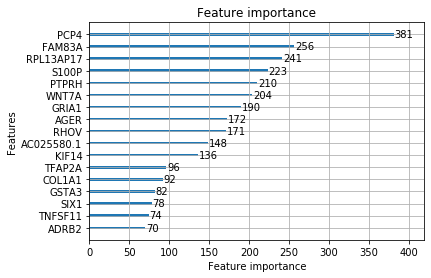

Accuracy1: 0.968
Accuracy2: 0.976
Accuracy3: 0.96


In [67]:
# ligthGBM
y1, y2, y3, pre1, pre2, pre3, Accuracy1, Accuracy2, Accuracy3 = lightGBMForecast(train_data, test_data)

In [68]:
# 将预测结果封装成文件
def lightGBMResult(y1, y2, y3, pre1, pre2, pre3):
    resuGoup1 = [y1, pre1]
    resGoup1 = pd.DataFrame(resuGoup1)
    resultGoup1 = resGoup1.T
    resultGoup1.columns = ['y1', 'pre1']

    resuGoup2 = [y2, pre2]
    resGoup2 = pd.DataFrame(resuGoup2)
    resultGoup2 = resGoup2.T
    resultGoup2.columns = ['y2', 'pre2']

    resuGoup3 = [y3, pre3]
    resGoup3 = pd.DataFrame(resuGoup3)
    resultGoup3 = resGoup3.T
    resultGoup3.columns = ['y3', 'pre3']
    resultGoup1.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/lightGBM/resultGoup1.txt', sep='\t', header=True, index=False)
    resultGoup2.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/lightGBM/resultGoup2.txt', sep='\t', header=True, index=False)
    resultGoup3.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/lightGBM/resultGoup3.txt', sep='\t', header=True, index=False)
#     resultGoup1.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/lightGBM/resultAllGoup1.txt', sep='\t', header=True, index=False)
#     resultGoup2.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/lightGBM/resultAllGoup2.txt', sep='\t', header=True, index=False)
#     resultGoup3.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/lightGBM/resultAllGoup3.txt', sep='\t', header=True, index=False)
    print(resultGoup3.shape)

In [69]:
# 存储文件
lightGBMResult(y1, y2, y3, pre1, pre2, pre3)

(125, 2)


In [97]:
# XGBoost
# Accuracy1: 0.968
# Accuracy2: 0.92
# Accuracy3: 0.952
# lightFBM
# Accuracy1: 0.96
# Accuracy2: 0.96
# Accuracy3: 0.936

In [21]:
import csv
import math
import numpy as np
import pandas as pd
import datetime
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from sklearn import preprocessing

Using TensorFlow backend.


In [22]:
# 1.初始化参数
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2)
    # 权重和偏置矩阵
    w1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    w2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    # 通过字典存储参数
    parameters = {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2}
    return parameters

In [23]:
# 2.前向传播
def forward_propagation(X, parameters):
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']

    # 通过前向传播来计算a2
    # 这个地方需注意矩阵加法：虽然(w1*X)和b1的维度不同，但可以相加
    z1 = np.dot(w1, X) + b1     
    # 使用tanh作为第一层的激活函数
    a1 = np.tanh(z1)            
    z2 = np.dot(w2, a1) + b2
    # 使用sigmoid作为第二层的激活函数
    a2 = 1 / (1 + np.exp(-z2))  

    # 通过字典存储参数
    cache = {'z1': z1, 'a1': a1, 'z2': z2, 'a2': a2}

    return a2, cache

In [24]:
# 3.计算代价函数
def compute_cost(a2, Y, parameters):
    m = Y.shape[1]      # Y的列数即为总的样本数

    # 采用交叉熵（cross-entropy）作为代价函数
    logprobs = np.multiply(np.log(a2), Y) + np.multiply((1 - Y), np.log(1 - a2))
    cost = - np.sum(logprobs) / m

    return cost

In [25]:
# 4.反向传播（计算代价函数的导数）
def backward_propagation(parameters, cache, X, Y):
    m = Y.shape[1]

    w2 = parameters['w2']

    a1 = cache['a1']
    a2 = cache['a2']

    # 反向传播，计算dw1、db1、dw2、db2
    dz2 = a2 - Y
    dw2 = (1 / m) * np.dot(dz2, a1.T)
    db2 = (1 / m) * np.sum(dz2, axis=1, keepdims=True)
    dz1 = np.multiply(np.dot(w2.T, dz2), 1 - np.power(a1, 2))
    dw1 = (1 / m) * np.dot(dz1, X.T)
    db1 = (1 / m) * np.sum(dz1, axis=1, keepdims=True)

    grads = {'dw1': dw1, 'db1': db1, 'dw2': dw2, 'db2': db2}

    return grads

In [26]:
# 5.更新参数
def update_parameters(parameters, grads, learning_rate=0.0075):
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']

    dw1 = grads['dw1']
    db1 = grads['db1']
    dw2 = grads['dw2']
    db2 = grads['db2']

    # 更新参数
    w1 = w1 - dw1 * learning_rate
    b1 = b1 - db1 * learning_rate
    w2 = w2 - dw2 * learning_rate
    b2 = b2 - db2 * learning_rate

    parameters = {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2}

    return parameters

In [27]:
# 建立神经网络
def nn_model(X, Y, n_h, n_input, n_output, num_iterations=10000, print_cost=False):
    np.random.seed(3)
    
    # 输入层节点数
    n_x = n_input           
    # 输出层节点数
    n_y = n_output          

    # 1.初始化参数
    parameters = initialize_parameters(n_x, n_h, n_y)

    # 梯度下降循环
    for i in range(0, num_iterations):
        # 2.前向传播
        a2, cache = forward_propagation(X, parameters)
        # 3.计算代价函数
        cost = compute_cost(a2, Y, parameters)
        # 4.反向传播
        grads = backward_propagation(parameters, cache, X, Y)
        # 5.更新参数
        parameters = update_parameters(parameters, grads)

        # 每1000次迭代，输出一次代价函数
        if print_cost and i % 1000 == 0:
            print('迭代第%i次，代价函数为：%f' % (i, cost))

    return parameters

In [28]:
# 对模型进行测试
def predict(parameters, x_test, y_test):
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']

    z1 = np.dot(w1, x_test) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(w2, a1) + b2
    a2 = 1 / (1 + np.exp(-z2))

    # 结果的维度
    n_rows = y_test.shape[0]
    n_cols = y_test.shape[1]

    # 预测值结果存储
    output = np.empty(shape=(n_rows, n_cols), dtype=int)

    # 取出每条测试数据的预测结果
    for i in range(n_cols):
        # 将每条测试数据的预测结果（概率）存为一个行向量
        temp = np.zeros(shape=n_rows)
        for j in range(n_rows):
            temp[j] = a2[j][i]

        # 将每条结果（概率）从小到大排序，并获得相应下标
        sorted_dist = np.argsort(temp)
        length = len(sorted_dist)

        # 将概率最大的置为1，其它置为0
        for k in range(length):
            if k == sorted_dist[length - 1]:
                output[k][i] = 1
            else:
                output[k][i] = 0

#     print('预测结果：')
#     print(output)
#     print('真实结果：')
#     print(y_test)

#     count = 0
#     for k in range(0, n_cols):
#         if output[0][k] == y_test[0][k] and output[1][k] == y_test[1][k] and output[2][k] == y_test[2][k]:
#             count = count + 1

#     acc = count / int(y_test.shape[1]) * 100
#     print('准确率：%.2f%%' % acc)
    return output, y_test

In [29]:
def getPredAanY(output, y_test):
    y = []
    pred = []
    for i in range(output.shape[1]):
        if output[0][i] == 1:
            y.append(0)
        elif output[1][i] == 1:
            y.append(1)
        elif output[2][i] == 1:
            y.append(2)

    for i in range(y_test.shape[1]):
        if y_test[0][i] == 1:
            pred.append(0)
        elif y_test[1][i] == 1:
            pred.append(1)
        elif y_test[2][i] == 1:
            pred.append(2)
    return y, pred

In [30]:
# 获取计算评价指标的数据
def y_pre_bpnn(y, pred):
    y1 = []
    y2 = []
    y3 = []
    pre1 = []
    pre2 = []
    pre3 = []
    # 对实际值分组
    for i in y:
        if i == 0:
            y1.append(0)
        else:
            y1.append(1)

    for i in y:
        if i == 1:
            y2.append(0)
        else:
            y2.append(1)

    for i in y:
        if i == 2:
            y3.append(0)
        else:
            y3.append(1)
     # 对预测值分组       
    for i in pred:
        if i == 0:
            pre1.append(0)
        else:
            pre1.append(1)
    for i in pred:
        if i == 1:
            pre2.append(0)
        else:
            pre2.append(1)

    for i in pred:
        if i == 2:
            pre3.append(0)
        else:
            pre3.append(1)
    return y1, y2, y3, pre1, pre2, pre3

In [77]:
# BPNN 预测  函数封装
def BPNNForecast(clinical_express):
    # 数据准备
    label1 = []
    label2 = []
    label3 = []
    for i in clinical_express['label'].tolist():
        if i == 0:
            label1.append(1)
            label2.append(0)
            label3.append(0)
        elif i == 1:
            label1.append(0)
            label2.append(1)
            label3.append(0)
        elif i == 2:
            label1.append(0)
            label2.append(0)
            label3.append(1)
#     print(len(label1))
#     print(len(label2))
#     print(len(label3))
    clinical_express['label1'] = label1
    clinical_express['label2'] = label2
    clinical_express['label3'] = label3
    # 划分数据集
    train_data, test_data = load_data(clinical_express)
    X = train_data.iloc[:, 3:20].values.T       # 前13:20是特征
    Y = train_data.iloc[:, 21:24].values.T      # 后3列是标签
    Y = Y.astype('uint8')
    # 开始训练
    start_time = datetime.datetime.now()
    # 输入17个节点，隐层6个节点，输出3个节点，迭代10000次
    parameters = nn_model(X, Y, n_h=6, n_input=17, n_output=3, num_iterations=10000, print_cost=True)
    end_time = datetime.datetime.now()
    print("用时：" + str((end_time - start_time).seconds) + 's' + str(round((end_time - start_time).microseconds / 1000)) + 'ms')
    # 对模型进行测试
    x_test = test_data.iloc[:, 3:20].values.T
    y_test = test_data.iloc[:, 21:24].values.T
    y_test = y_test.astype('uint8')
    # 整个数据集
    x_all = clinical_express.iloc[:, 3:20].values.T
    y_all = clinical_express.iloc[:, 21:24].values.T
#     output, y_test = predict(parameters, x_all, y_all)
    output, y_test = predict(parameters, x_test, y_test)
    y, pred = getPredAanY(output, y_test)
    y1, y2, y3, pre1, pre2, pre3 = y_pre_bpnn(y, pred)
    Accuracy1, Accuracy2, Accuracy3 = calculate(y1, y2, y3, pre1, pre2, pre3)
    print('Accuracy1:', Accuracy1)
    print('Accuracy2:', Accuracy2)
    print('Accuracy3:', Accuracy3)
    return y1, y2, y3, pre1, pre2, pre3, Accuracy1, Accuracy2, Accuracy3

In [78]:
# BPNN
y1, y2, y3, pre1, pre2, pre3, Accuracy1, Accuracy2, Accuracy3 = BPNNForecast(clinical_express)

迭代第0次，代价函数为：2.079588
迭代第1000次，代价函数为：1.404198
迭代第2000次，代价函数为：0.638359
迭代第3000次，代价函数为：0.403249
迭代第4000次，代价函数为：0.309106
迭代第5000次，代价函数为：0.259732
迭代第6000次，代价函数为：0.229643
迭代第7000次，代价函数为：0.209149
迭代第8000次，代价函数为：0.194049
迭代第9000次，代价函数为：0.182277
用时：2s150ms
Accuracy1: 0.928
Accuracy2: 0.936
Accuracy3: 0.928


In [79]:
len(y1)

125

In [80]:
# 将预测结果封装成文件
def BPNNResult(y1, y2, y3, pre1, pre2, pre3):
    resuGoup1 = [y1, pre1]
    resGoup1 = pd.DataFrame(resuGoup1)
    resultGoup1 = resGoup1.T
    resultGoup1.columns = ['y1', 'pre1']

    resuGoup2 = [y2, pre2]
    resGoup2 = pd.DataFrame(resuGoup2)
    resultGoup2 = resGoup2.T
    resultGoup2.columns = ['y2', 'pre2']

    resuGoup3 = [y3, pre3]
    resGoup3 = pd.DataFrame(resuGoup3)
    resultGoup3 = resGoup3.T
    resultGoup3.columns = ['y3', 'pre3']
    resultGoup1.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/BPNN/resultGoup1.txt', sep='\t', header=True, index=False)
    resultGoup2.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/BPNN/resultGoup2.txt', sep='\t', header=True, index=False)
    resultGoup3.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/BPNN/resultGoup3.txt', sep='\t', header=True, index=False)
#     resultGoup1.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/BPNN/resultAllGoup1.txt', sep='\t', header=True, index=False)
#     resultGoup2.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/BPNN/resultAllGoup2.txt', sep='\t', header=True, index=False)
#     resultGoup3.to_csv('E:/cancerPrognosis/MyLUAD/code/forecast/BPNN/resultAllGoup3.txt', sep='\t', header=True, index=False)
    print(resultGoup3.shape)

In [81]:
# 存储文件
BPNNResult(y1, y2, y3, pre1, pre2, pre3)

(125, 2)


In [173]:
# 数据集划分
def load_data(dataset):
    data = dataset.values.tolist()
#     random.seed(1234)
    random.seed(12)
    random.shuffle(data)
    train_test = pd.DataFrame(data, columns = dataset.columns)
    dataset0 = train_test[train_test['label']==0]
    dataset1 = train_test[train_test['label']==1]
    dataset2 = train_test[train_test['label']==2]
    train_data0, test_data0 = train_test_split(dataset0, test_size=0.3, random_state=1234)
    train_data1, test_data1 = train_test_split(dataset1, test_size=0.3, random_state=1234)
    train_data2, test_data2 = train_test_split(dataset2, test_size=0.3, random_state=1234)
    train_data = pd.concat([train_data0,train_data1,train_data2],axis=0)
    test_data = pd.concat([test_data0,test_data1,test_data2],axis=0)
    return train_data, test_data

In [174]:
# 读取数据文件
clinical_express = pd.read_csv('E:/cancerPrognosis/MyLUAD/code/processing/lasso/lassoExp.txt', sep="\t")
# 获取数据
clinical_express = data_transform(clinical_express)
# 划分数据
train_data, test_data = load_data(clinical_express)
print(clinical_express.shape)

(414, 21)


In [175]:
# XGBoost
y1, y2, y3, pre1, pre2, pre3, Accuracy1, Accuracy2, Accuracy3 = xgboostForecast(train_data, test_data)

[0]	train-mlogloss:0.99442	test-mlogloss:1.02326
[1]	train-mlogloss:0.90535	test-mlogloss:0.95991
[2]	train-mlogloss:0.83222	test-mlogloss:0.90880
[3]	train-mlogloss:0.76413	test-mlogloss:0.85404
[4]	train-mlogloss:0.70420	test-mlogloss:0.80637
[5]	train-mlogloss:0.65462	test-mlogloss:0.76673
[6]	train-mlogloss:0.60489	test-mlogloss:0.73026
[7]	train-mlogloss:0.56187	test-mlogloss:0.70070
[8]	train-mlogloss:0.51906	test-mlogloss:0.67346
[9]	train-mlogloss:0.48423	test-mlogloss:0.64501
[10]	train-mlogloss:0.44976	test-mlogloss:0.61513
[11]	train-mlogloss:0.41962	test-mlogloss:0.59310
[12]	train-mlogloss:0.39236	test-mlogloss:0.57132
[13]	train-mlogloss:0.37019	test-mlogloss:0.54913
[14]	train-mlogloss:0.34616	test-mlogloss:0.53023
[15]	train-mlogloss:0.32799	test-mlogloss:0.51307
[16]	train-mlogloss:0.31005	test-mlogloss:0.50060
[17]	train-mlogloss:0.29162	test-mlogloss:0.48462
[18]	train-mlogloss:0.27398	test-mlogloss:0.47032
[19]	train-mlogloss:0.26066	test-mlogloss:0.45821
[20]	train

In [176]:
print('Accuracy1:', Accuracy1)
print('Accuracy2:', Accuracy2)
print('Accuracy3:', Accuracy3)

Accuracy1: 0.968
Accuracy2: 0.936
Accuracy3: 0.92


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1406
[LightGBM] [Info] Number of data points in the train set: 289, number of used features: 17
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Info] Start training from score -1.166617
[LightGBM] [Info] Start training from score -1.112550
[LightGBM] [Info] Start training from score -1.022036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

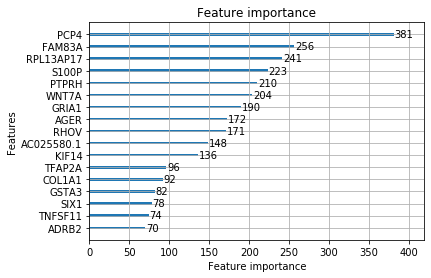

Accuracy1: 0.968
Accuracy2: 0.976
Accuracy3: 0.96


In [181]:
# ligthGBM
y1, y2, y3, pre1, pre2, pre3, Accuracy1, Accuracy2, Accuracy3 = lightGBMForecast(train_data, test_data)

In [182]:
print('Accuracy1:', Accuracy1)
print('Accuracy2:', Accuracy2)
print('Accuracy3:', Accuracy3)

Accuracy1: 0.968
Accuracy2: 0.976
Accuracy3: 0.96


In [183]:
# BPNN
y1, y2, y3, pre1, pre2, pre3, Accuracy1, Accuracy2, Accuracy3 = BPNNForecast(clinical_express)

迭代第0次，代价函数为：2.079588
迭代第1000次，代价函数为：1.404198
迭代第2000次，代价函数为：0.638359
迭代第3000次，代价函数为：0.403249
迭代第4000次，代价函数为：0.309106
迭代第5000次，代价函数为：0.259732
迭代第6000次，代价函数为：0.229643
迭代第7000次，代价函数为：0.209149
迭代第8000次，代价函数为：0.194049
迭代第9000次，代价函数为：0.182277
用时：2s30ms
Accuracy1: 0.928
Accuracy2: 0.936
Accuracy3: 0.928


In [184]:
print('Accuracy1:', Accuracy1)
print('Accuracy2:', Accuracy2)
print('Accuracy3:', Accuracy3)

Accuracy1: 0.928
Accuracy2: 0.936
Accuracy3: 0.928


In [172]:
# prtoch
# y1, y2, y3, pre1, pre2, pre3, Accuracy1, Accuracy2, Accuracy3 = prtochForecast(clinical_express)

In [ ]:
print('Accuracy1:', Accuracy1)
print('Accuracy2:', Accuracy2)
print('Accuracy3:', Accuracy3)